In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.applications import VGG16

In [7]:
df = pd.read_csv("data/pokemon.csv")
df["image_name"] = df["Name"] + ".png"
df.columns = df.columns.str.lower()
df

,name,type1,type2,image_name
0,bulbasaur,Grass,Poison,bulbasaur.png
1,ivysaur,Grass,Poison,ivysaur.png
2,venusaur,Grass,Poison,venusaur.png
3,charmander,Fire,NaN,charmander.png
4,charmeleon,Fire,NaN,charmeleon.png
...,...,...,...,...
804,stakataka,Rock,Steel,stakataka.png
805,blacephalon,Fire,Ghost,blacephalon.png
806,zeraora,Electric,NaN,zeraora.png
807,meltan,Steel,NaN,meltan.png


In [15]:
#import splitfolders
#splitfolders.ratio('data', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

In [5]:
train_list = []
for image in os.listdir("output/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("output/test/images"):
    test_list.append(image)
    
val_list = []
for image in os.listdir("output/val/images"):
    val_list.append(image)

In [ ]:
train_df = df.loc[df.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = df.loc[df.apply(lambda row: row["image_name"] in test_list, axis=1)]
val_df = df.loc[df.apply(lambda row: row["image_name"] in val_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"
val_df["split"] = "val"

pdList = [train_df, test_df, val_df]
df = pd.concat(pdList)

In [ ]:
df = df.sort_index()

In [ ]:
train_dir = 'output/train/images'
test_dir = 'output/test/images'
val_dir = 'output/val/images'

#for index, row in df.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if class_label not in os.listdir(val_dir):
        os.mkdir(os.path.join(val_dir, class_label))       
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label, filename))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label, filename))
    elif row['split'] == 'val':
        shutil.move(os.path.join(val_dir, filename), os.path.join(val_dir, class_label, filename))

In [36]:
train_path = "output/train/images"
test_path = "output/test/images"
val_path = "output/val/images"

data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = data_gen.flow_from_directory(train_path, target_size=(224, 224), color_mode='rgb', 
                                                    batch_size=5, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

val_generator = data_gen.flow_from_directory(val_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

Found 647 images belonging to 18 classes.
Found 82 images belonging to 18 classes.
Found 80 images belonging to 18 classes.


In [41]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))

In [42]:
bce = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])

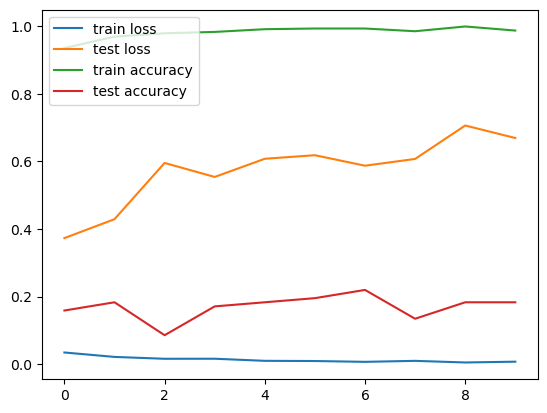

In [62]:
base_model = model.fit(
        train_generator,
        steps_per_epoch=100, verbose = 0, validation_data = test_generator, 
        epochs=10)

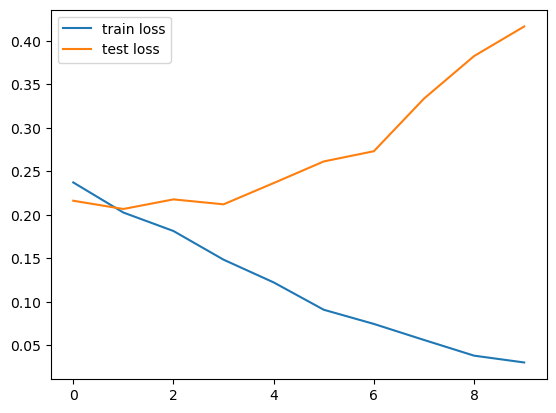

In [60]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left");

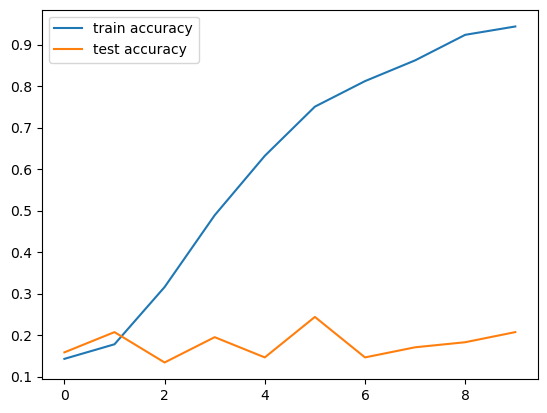

In [61]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left");